In [1]:
import pandas as pd

In [4]:
data = pd.read_csv('User_Data.csv')

In [5]:
data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


Root
   | GINI impurity of the node: 0.46
   | Class distribution in the node: {0: 257, 1: 143}
   | Predicted class: 0
|-------- Split rule: Age <= 42.5
           | GINI impurity of the node: 0.27
           | Class distribution in the node: {0: 239, 1: 46}
           | Predicted class: 0
|---------------- Split rule: EstimatedSalary <= 90500.0
                   | GINI impurity of the node: 0.07
                   | Class distribution in the node: {0: 232, 1: 9}
                   | Predicted class: 0
|------------------------ Split rule: Age <= 36.5
                           | GINI impurity of the node: 0.0
                           | Class distribution in the node: {0: 162}
                           | Predicted class: 0
|------------------------ Split rule: Age > 36.5
                           | GINI impurity of the node: 0.2
                           | Class distribution in the node: {0: 70, 1: 9}
                           | Predicted class: 0
|---------------- Split rule: 

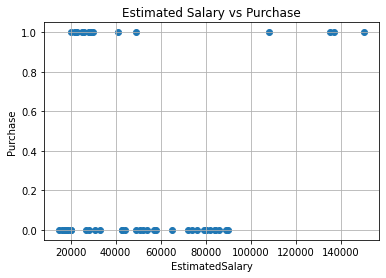

In [6]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
import pandas as pd 
import numpy as np 
from collections import Counter
import matplotlib.pyplot as plt

class Node: 

    def __init__(
        self, 
        Y: list,
        X: pd.DataFrame,
        min_samples_split=None,
        max_depth=None,
        depth=None,
        node_type=None,
        rule=None
    ):
        self.Y = Y 
        self.X = X

        self.min_samples_split = min_samples_split if min_samples_split else 20
        self.max_depth = max_depth if max_depth else 5

        self.depth = depth if depth else 0
        self.features = list(self.X.columns)
        self.node_type = node_type if node_type else 'root'
        self.rule = rule if rule else ""
        self.counts = Counter(Y)
        self.gini_impurity = self.get_GINI()
        counts_sorted = list(sorted(self.counts.items(), key=lambda item: item[1]))
        yhat = None
        if len(counts_sorted) > 0:
            yhat = counts_sorted[-1][0]
        self.yhat = yhat 
        self.n = len(Y)
        self.left = None 
        self.right = None 
        self.best_feature = None 
        self.best_value = None 

    @staticmethod
    def GINI_impurity(y1_count: int, y2_count: int) -> float:
        if y1_count is None:
            y1_count = 0

        if y2_count is None:
            y2_count = 0

        n = y1_count + y2_count
        
        if n == 0:
            return 0.0
        p1 = y1_count / n
        p2 = y2_count / n
        gini = 1 - (p1 ** 2 + p2 ** 2)
        return gini

    @staticmethod
    def ma(x: np.array, window: int) -> np.array:
        return np.convolve(x, np.ones(window), 'valid') / window

    def get_GINI(self):
        y1_count, y2_count = self.counts.get(0, 0), self.counts.get(1, 0)
        return self.GINI_impurity(y1_count, y2_count)

    def best_split(self) -> tuple:
        df = self.X.copy()
        df['Y'] = self.Y
        GINI_base = self.get_GINI()
        max_gain = 0

        best_feature = None
        best_value = None

        for feature in self.features:
            Xdf = df.dropna().sort_values(feature)
            xmeans = self.ma(Xdf[feature].unique(), 2)

            for value in xmeans:
                left_counts = Counter(Xdf[Xdf[feature]<value]['Y'])
                right_counts = Counter(Xdf[Xdf[feature]>=value]['Y'])
                y0_left, y1_left, y0_right, y1_right = left_counts.get(0, 0), left_counts.get(1, 0), right_counts.get(0, 0), right_counts.get(1, 0)
                gini_left = self.GINI_impurity(y0_left, y1_left)
                gini_right = self.GINI_impurity(y0_right, y1_right)
                n_left = y0_left + y1_left
                n_right = y0_right + y1_right
                w_left = n_left / (n_left + n_right)
                w_right = n_right / (n_left + n_right)
                wGINI = w_left * gini_left + w_right * gini_right
                GINIgain = GINI_base - wGINI
                if GINIgain > max_gain:
                    best_feature = feature
                    best_value = value 
                    max_gain = GINIgain

        return (best_feature, best_value)

    def grow_tree(self):
        df = self.X.copy()
        df['Y'] = self.Y
        if (self.depth < self.max_depth) and (self.n >= self.min_samples_split):
            best_feature, best_value = self.best_split()

            if best_feature is not None:
                self.best_feature = best_feature
                self.best_value = best_value
                left_df, right_df = df[df[best_feature]<=best_value].copy(), df[df[best_feature]>best_value].copy()
                left = Node(
                    left_df['Y'].values.tolist(), 
                    left_df[self.features], 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split, 
                    node_type='left_node',
                    rule=f"{best_feature} <= {round(best_value, 3)}"
                    )

                self.left = left 
                self.left.grow_tree()

                right = Node(
                    right_df['Y'].values.tolist(), 
                    right_df[self.features], 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split,
                    node_type='right_node',
                    rule=f"{best_feature} > {round(best_value, 3)}"
                    )

                self.right = right
                self.right.grow_tree()

    def print_info(self, width=4):
        const = int(self.depth * width ** 1.5)
        spaces = "-" * const
        
        if self.node_type == 'root':
            print("Root")
        else:
            print(f"|{spaces} Split rule: {self.rule}")
        print(f"{' ' * const}   | GINI impurity of the node: {round(self.gini_impurity, 2)}")
        print(f"{' ' * const}   | Class distribution in the node: {dict(self.counts)}")
        print(f"{' ' * const}   | Predicted class: {self.yhat}")   

    def print_tree(self):
        self.print_info() 
        if self.left is not None: 
            self.left.print_tree()

        if self.right is not None:
            self.right.print_tree()

    def predict(self, X:pd.DataFrame):
        predictions = []

        for _, x in X.iterrows():
            values = {}
            for feature in self.features:
                values.update({feature: x[feature]})
        
            predictions.append(self.predict_obs(values))
        
        return predictions

    def predict_obs(self, values: dict) -> int:
        cur_node = self
        while cur_node.depth < cur_node.max_depth:
            best_feature = cur_node.best_feature
            best_value = cur_node.best_value

            if cur_node.n < cur_node.min_samples_split:
                break 

            if (values.get(best_feature) < best_value):
                if self.left is not None:
                    cur_node = cur_node.left
            else:
                if self.right is not None:
                    cur_node = cur_node.right
            
        return cur_node.yhat
        
if __name__ == '__main__':
    d = pd.read_csv("User_Data.csv")[['Age', 'EstimatedSalary', 'Gender', 'Purchased']].dropna()
    d['Gender'] = label_encoder.fit_transform(d['Gender']) 
    X = d[['Age', 'EstimatedSalary', 'Gender']]
    Y = d['Purchased'].values.tolist()
    root = Node(Y, X, max_depth=3, min_samples_split=100)
    root.grow_tree()
    root.print_tree()
    Xsubset = X.copy()
    Xsubset['yhat'] = root.predict(Xsubset)
    plt.scatter(Xsubset['EstimatedSalary'][:50],Xsubset['yhat'][:50])
    plt.grid(True)
    plt.xlabel('EstimatedSalary')
    plt.ylabel('Purchase')
    plt.title('Estimated Salary vs Purchase')